In [15]:
import numpy as np
from qiskit import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import random
import math
from qiskit.tools.monitor import job_monitor
%matplotlib inline

In [2]:
# Choose a real device to simulate
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()

In [3]:
import numpy as np

backend_defaults = backend.defaults()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Sampling time: 0.2222222222222222 ns
Qubit 0 has an estimated frequency of 4.974445794773773 GHz.
The sweep will go from 4.954445794773773 GHz to 4.994445794773773 GHz in steps of 1.0 MHz.


In [49]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [50]:
drive_sigma

336

In [5]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [6]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit)

In [7]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [8]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

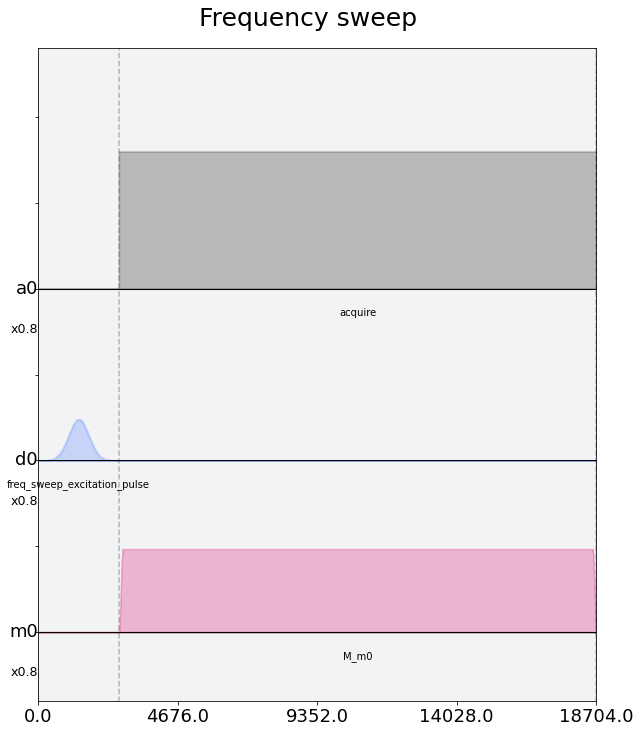

In [12]:
schedule.draw(label=True, scaling=0.8)

In [13]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job = backend.run(frequency_sweep_program)

print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5ee0ffbe7605e90012f28943
Job Status: job has successfully run


In [14]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

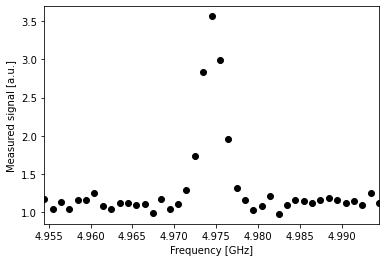

In [15]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [20]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [3, 4.975, 1, 3])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

NameError: name 'sweep_values' is not defined

In [17]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97446 GHz to 4.97456 GHz.


In [34]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [35]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

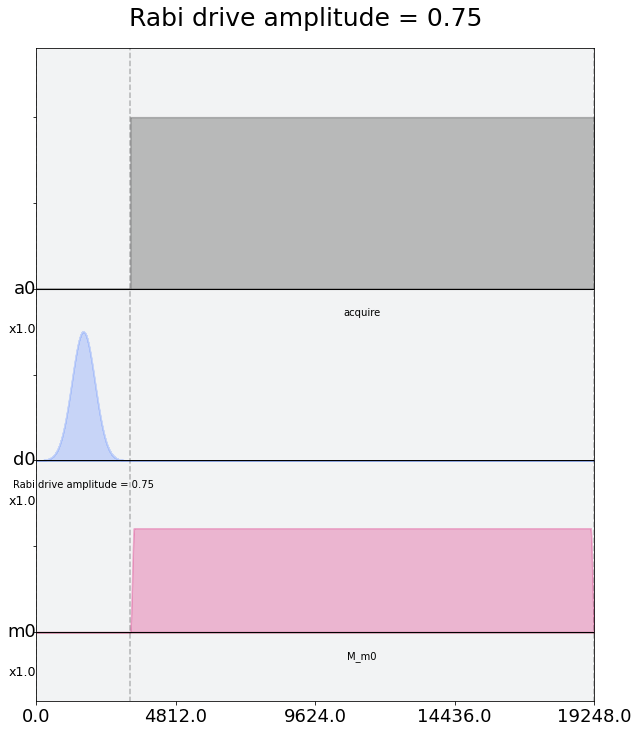

In [36]:
rabi_schedules[-1].draw(label=True, scaling=1.0)

In [37]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[qubit]}]
                                                * num_rabi_points)
job = backend.run(rabi_experiment_program)
print(job.job_id())
job_monitor(job)

5ee90c01c6c76f001a369f86
Job Status: job has successfully run


In [42]:
rabi_results = job.result(timeout=120)

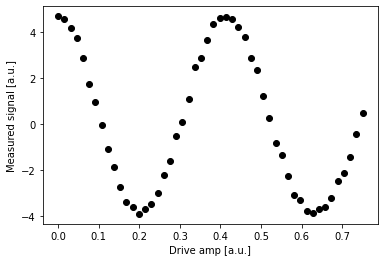

In [43]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

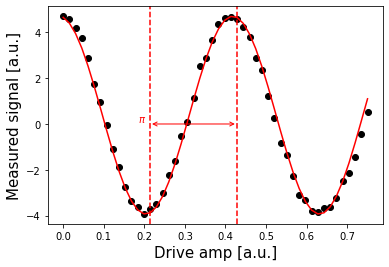

In [45]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [4, 0.1, 0.3, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [46]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")
print(f"Duration = {drive_samples}")
print(f"Sigma = {drive_sigma}")

pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

Pi Amplitude = 0.21401256646277822
Duration = 3248
Sigma = 400


In [27]:
# Create two schedules

# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += Play(pi_pulse, drive_chan)  # We found this in Part 2A above
exc_schedule += measure << exc_schedule.duration

In [28]:
# Execution settings
num_shots = 1024

gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

print(job.job_id())
job = backend.run(gnd_exc_program)
job_monitor(job)

5ee104c54e03420013c4eeb5
Job Status: job has successfully run


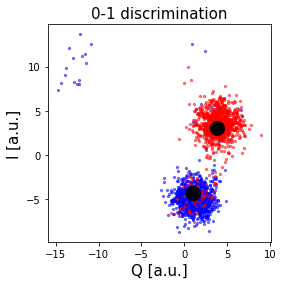

In [29]:
gnd_exc_results = job.result(timeout=120)
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [30]:
# Now perform Richardson extrapolation with our Pi pulse (X gate)
scheds = []

num_steps = 7
steps = range(1, (num_steps * 2) + 1, 2)

for i in steps:  
    exc_schedule = pulse.Schedule(name="extrapolating {} step(s)".format(i))
    
    # Apply odd numbers of the Pi pulse
    for j in range(i):
        exc_schedule += Play(pi_pulse, drive_chan)  # We found this in Part 2A above
    
    exc_schedule += measure << exc_schedule.duration
    scheds.append(exc_schedule)

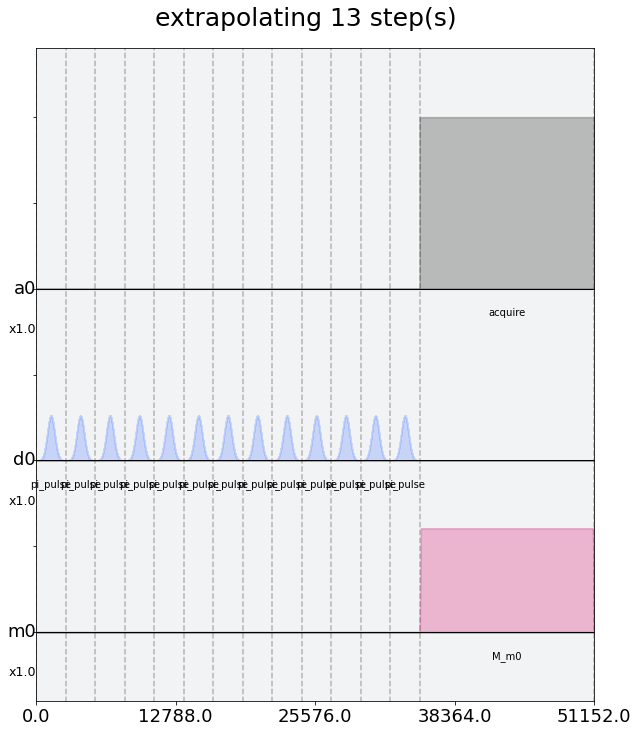

In [31]:
scheds[-1].draw(label=True, scaling=1.0)

In [32]:
# Execution settings
num_shots = 1024

richardson_program = assemble(scheds,
                           backend=backend,
                           meas_level=2,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * num_steps)

print(job.job_id())
job = backend.run(richardson_program)
job_monitor(job)

5ee10af1459add001281c247
Job Status: job has successfully run


In [34]:
richardson_results = job.result(timeout=120)
res = []

for i in range(num_steps):
    res.append(richardson_results.get_counts(i))
    
# Calculate the expectation value for each of the experiments
expectation = [(x['0'] - x['1']) / num_shots for x in res]

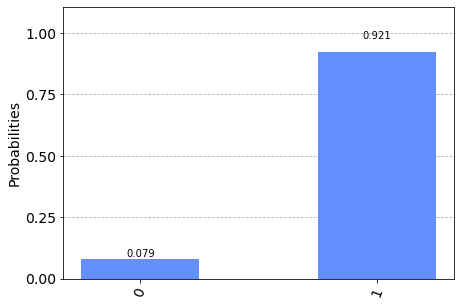

In [35]:
# This is fairly close; we should always end at |1>
plot_histogram(res[0])

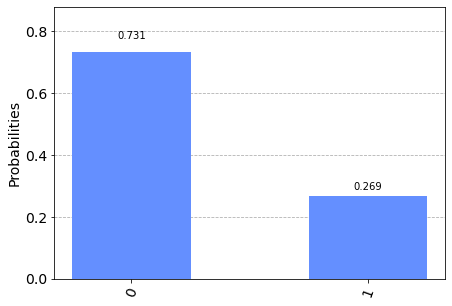

In [36]:
# This is really bad, but we also applied ~13 Pi pulses
plot_histogram(res[-1])

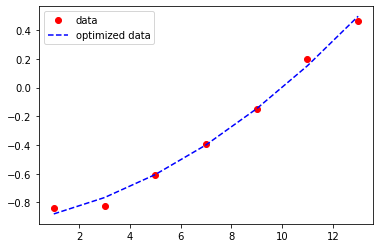

y-intercept = -0.9194684710942248


In [37]:
def quad(x, a, b, c):    
    B = (a*(x**2.0)) + (b*x) + c
    return B

param, param_cov = curve_fit(quad, list(steps), expectation)
ans = [quad(x, param[0], param[1], param[2]) for x in list(steps)]

plt.plot(steps, expectation, 'o', color ='red', label ="data") 
plt.plot(steps, ans, '--', color ='blue', label ="optimized data") 
plt.legend() 
plt.show() 

print(f'y-intercept = {quad(0, param[0], param[1], param[2])}')

In [131]:
stretched_scheds = []
width = []

num_steps = 7

for i in range(num_steps):
    drive_sigma_stretch = 0.075+(i * 0.01)                    
    drive_samples_stretch = drive_sigma_us*8        
                                               

    drive_sigma = get_closest_multiple_of_16(drive_sigma_stretch * us /dt)       # The width of the gaussian in units of dt
    drive_samples = get_closest_multiple_of_16(drive_samples_stretch * us /dt)   # The truncating parameter in units of dt
    width.append(drive_sigma)
    
    # Make stretched pulse
    pi_pulse_2 = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')
    
    pi_schedule = pulse.Schedule(name=f"stretched pulse {i}")
    pi_schedule += Play(pi_pulse_2, drive_chan)  
    pi_schedule += measure << pi_schedule.duration
    stretched_scheds.append(pi_schedule)

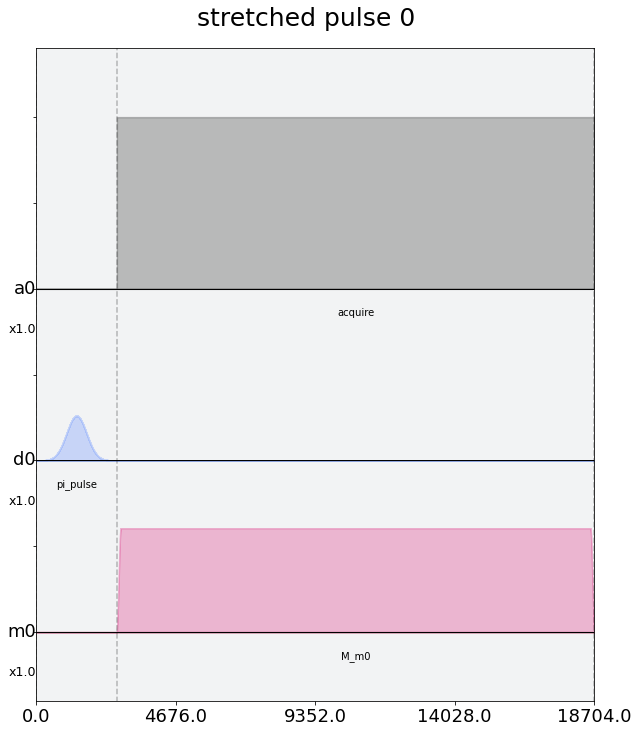

In [117]:
stretched_scheds[0].draw(label=True, scaling=1.0)

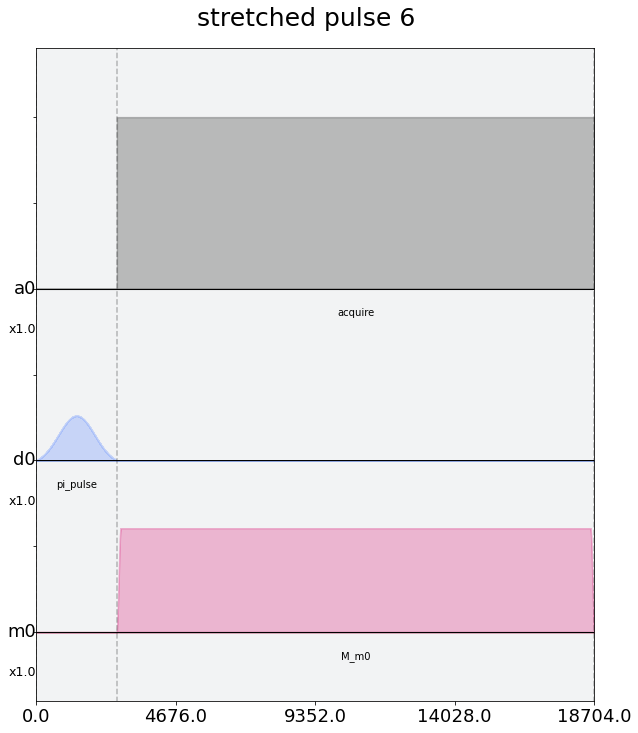

In [118]:
stretched_scheds[-1].draw(label=True, scaling=1.0)

In [119]:
# Execution settings
num_shots = 1024

stretch_program = assemble(stretched_scheds,
                           backend=backend,
                           meas_level=2,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * num_steps)

print(job.job_id())
job = backend.run(stretch_program)
job_monitor(job)

5ee11d14c926d60014451e02
Job Status: job has successfully run


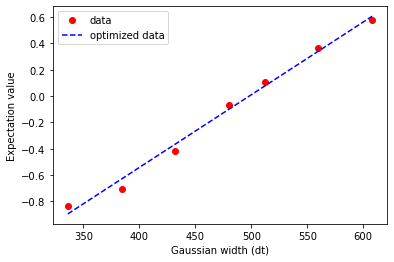

In [138]:
stretched_results = job.result(timeout=120)
res = []

for i in range(num_steps):
    res.append(stretched_results.get_counts(i))
    
def lin(x, a, b):    
    B = (a*x) + b
    return B

# Calculate the expectation value for each of the experiments
expectation = [(x['0'] - x['1']) / num_shots for x in res]

param, param_cov = curve_fit(lin, width, expectation)
ans = [lin(x, param[0], param[1]) for x in width]

plt.plot(width, expectation, 'o', color ='red', label ="data") 
plt.plot(width, ans, '--', color ='blue', label ="optimized data") 
plt.ylabel('Expectation value')
plt.xlabel('Gaussian width (dt)')
plt.legend() 
plt.show() 
